# simple MNIST_demo


In [3]:
import sys
import os
import random
import tqdm
from os.path import join

import struct
from array import array

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision

from torchvision.transforms import transforms

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import sys
import os

# Add the /root/src directory to sys.path
sys.path.append(os.path.abspath("../src"))
from utils.data_extraction import MNISTDataReader  # Replace with actual function name

In [55]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# set seed for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cuda


## Loading in MNIST data

In [7]:
# # Load MNIST from TorchVision
# torchvision.datasets.MNIST(root="../data", train=True, download=True) 
# torchvision.datasets.MNIST(root="../data", train=False, download=True)

input_path = os.path.abspath(os.path.join(os.getcwd(), "../data/MNIST/raw")).replace("\\","/") +"/"
training_images_filepath = input_path + 'train-images-idx3-ubyte'
training_labels_filepath = input_path + 'train-labels-idx1-ubyte'
test_images_filepath = input_path + 't10k-images-idx3-ubyte'
test_labels_filepath = input_path + 't10k-labels-idx1-ubyte'

mnist_dataloader = MNISTDataReader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()


# basic exploratory analysis

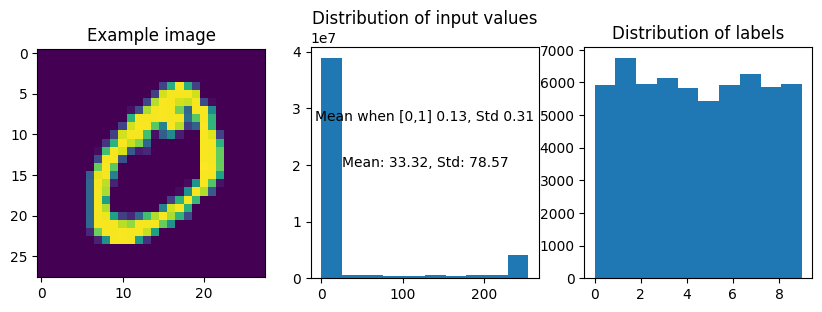

In [ ]:
# basic exploratory analysis
fig = plt.figure(figsize=(10, 3))
# plot example image
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Example image")
ax1.imshow(x_train[1]);
# plot distribtuion of input values
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("Distribution of input values")
ax2.text(0.5, 0.5, f"Mean: {x_train.flatten().mean():.2f}, Std: {x_train.flatten().std():.2f}",
         ha='center', va='center', transform=ax2.transAxes)
ax2.text(0.5, 0.7, f"Mean when [0,1] {x_train.flatten().mean()/255:.2f}, Std {x_train.flatten().std()/255:.2f}",
         ha='center', va='center', transform=ax2.transAxes)

ax2.hist(x_train.flatten());
# plot distribution of labels

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("Distribution of labels")
ax3.hist(y_train);

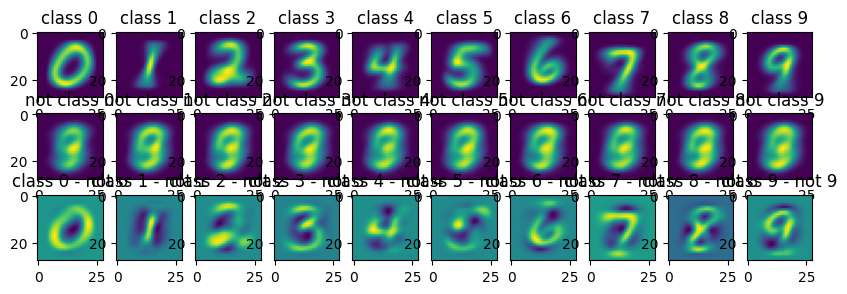

In [6]:
fig = plt.figure(figsize = (10,3))

for i in range(0,10):
    ax1 = fig.add_subplot(3,10,i+1)
    ax1.imshow(x_train[y_train == i].mean(axis=0).reshape(28,28))
    ax1.set_title(f"class {i}")
    ax2 = fig.add_subplot(3,10,i+11)
    ax2.imshow(x_train[y_train != i].mean(axis=0).reshape(28,28))
    ax2.set_title(f"not class {i}")
    ax3 = fig.add_subplot(3,10,i+21)
    ax3.imshow(x_train[y_train == i].mean(axis=0).reshape(28,28) - x_train[y_train != i].mean(axis=0).reshape(28,28))
    ax3.set_title(f"class {i} - not {i}")

## creating dataset and loaders 

In [139]:
## define datasets 
class ImageDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.transform = transforms.Compose([
            transforms.ToTensor(), #autoconverts scales to [0,1]
            #transforms.Normalize((0.5,), (0.5,)) #normalizes to [-1,1] - alternatively can use transforms.Normalize((0.1307,), (0.3081,)) - specific for MNIST
        ])

        self.x_data = np.array(x_data, copy=True)
        self.y_data = np.array(y_data, copy=True)
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        # Convert numpy arrays to torch tensors
        x = self.transform(self.x_data[idx]) #dont want to squeeze here as we want to keep the [CxHxW] even if one 1 channel
        y = torch.LongTensor([self.y_data[idx]]).squeeze()
        return x, y


class FlatDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.transform = transforms.Compose([
            transforms.ToTensor(), #autoconverts scales to [0,1]
            #transforms.Normalize((0.5,), (0.5,)) #normalizes to [-1,1] - alternatively can use transforms.Normalize((0.1307,), (0.3081,)) - specific for MNIST
        ])
        self.x_data = np.array(x_data, copy=True)
        self.y_data = np.array(y_data, copy=True)
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.transform(self.x_data[idx]).view(1,-1).squeeze()
        y = torch.LongTensor([self.y_data[idx]]).squeeze()
        return x, y

# Create datset and dataloader
image_train_dataset = ImageDataset(x_train, y_train)
image_train_dataloader = DataLoader(image_train_dataset, batch_size=32, shuffle=True)
image_test_dataset = ImageDataset(x_test, y_test)
image_test_dataloader = DataLoader(image_test_dataset, batch_size=32, shuffle=False)

flat_train_dataset = FlatDataset(x_train, y_train)
flat_train_dataloader = DataLoader(flat_train_dataset, batch_size=32, shuffle=True)
flat_test_dataset = FlatDataset(x_test, y_test)
flat_test_dataloader = DataLoader(flat_test_dataset, batch_size=32, shuffle=False)


Define the models - 
1. Logistic regression
2. FCNN
3. very basic CNN
4. CNN based on efficient net paper

# Metric definition

In [84]:
def classification_metrics(predictions,labels):
    outputs = {
        "Accuracy":(predictions == labels).mean()
    }
    print(outputs)
    return outputs

# logistic regression baseline

In [8]:
# flatten and stack inputs to feed into logreg [60000,28,28] -> [60000,28*28]
x_train_flat = x_train.reshape(x_train.shape[0],-1)
x_test_flat = x_test.reshape(x_test.shape[0],-1)
# (x_train[0].flatten() == x_train_flat[0]).all()

logregmodel = LogisticRegression(max_iter=1000)
logregmodel.fit(x_train_flat, y_train)

c:\Users\bruno\miniconda3\envs\cards\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [ ]:
x_test_flat = x_test.reshape(x_test.shape[0],-1)
classification_metrics(logreg)
(logregmodel.predict(x_test_flat) == y_test).mean()

0.9202

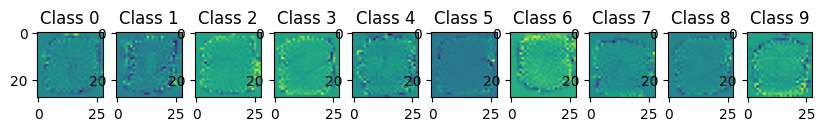

In [10]:
fig = plt.figure(figsize=(10,3))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(logregmodel.coef_[i].reshape(28,28))
    ax.set_title(f"Class {i}")

# Deep learning models

# Multilayer Perceptron

In [11]:
# Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.fc1(x) 
        return x

In [74]:
mlp_model = MLP().to(device)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(5):
    # training loop
    train_loss = []
    for batch_x, batch_y in flat_train_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device) # move intputs to GPU

        optimizer.zero_grad()
        output = mlp_model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    train_losses.append(train_loss)

    # validation loop
    with torch.no_grad():
        val_loss = []
        for batch_x, batch_y in flat_test_dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device) # move intputs to GPU
            
            output = mlp_model(batch_x)
            loss = loss_fn(output, batch_y)

            val_loss.append(loss.item())
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch} train_loss: {np.mean(train_loss):.4} val_loss: {np.mean(val_loss):.4}")

Epoch 0 train_loss: 0.4633 val_loss: 0.3051
Epoch 1 train_loss: 0.3027 val_loss: 0.2838
Epoch 2 train_loss: 0.2821 val_loss: 0.2745
Epoch 3 train_loss: 0.2726 val_loss: 0.2714
Epoch 4 train_loss: 0.2666 val_loss: 0.2673


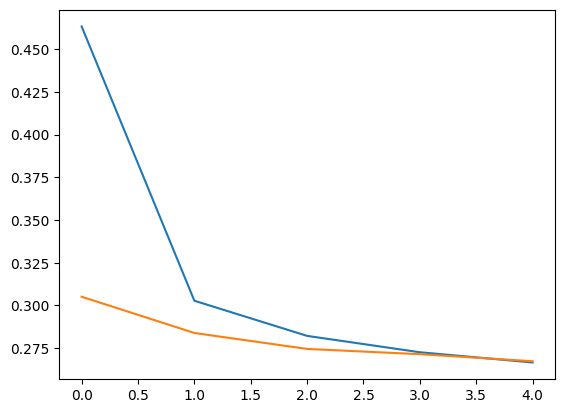

In [75]:
plt.plot(np.array(train_losses).mean(axis = 1))
plt.plot(np.array(val_losses).mean(axis = 1))

In [134]:
mlp_model(next(iter(flat_test_dataloader))[0].to(device)).shape
# .argmax(dim=1).detach().cpu().numpy()

torch.Size([32, 10])

In [76]:
predictions = []
set_seeds()
for i in range(100):
    output = torch.rand((32,10))
    predictions.append(output.argmax(dim=1).detach().cpu().numpy())
np.concatenate(predictions)

array([3, 0, 3, ..., 2, 4, 0], dtype=int64)

In [ ]:
predictions = []
with torch.no_grad():
    for batch_x, batch_y in flat_test_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output = mlp_model(batch_x)
        predictions.append(output.argmax(dim=1).detach().cpu().numpy())
predictions = np.concatenate(predictions)

def classification_metrics(predictions,labels):
    outputs = {
        "Accuracy":(predictions == labels).mean()
    }
    print(outputs)
    return outputs
classification_metrics(predictions,y_test);

{'Accuracy': 0.9254}


# Convolutional Neural Networks

## Basic CNN 

In [168]:
#define a basic CNN
class BasicCNN(nn.Module):
    def __init__(self,kernel_size=3,stride=1,padding=1):
        super(BasicCNN, self).__init__()
        # inputs are [1, 28, 28]
        # defaults are kernel_size=3, stride=1, padding=1
        # output is [32, 28+2*padding-kernel_size+1, 28+2*padding-kernel_size+1]
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, stride=stride, padding=padding) # [1, 28, 28] -> [32, 28, 28]
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # [32, 28, 28] -> [32, 14, 14] 
        self.relu = nn.ReLU() # [32, 14, 14] -> [32, 14, 14]
        self.flatten = nn.Flatten() # [32, 14, 14] -> [32*14*14] ([6272])
        self.fc1 = nn.Linear(32*14*14, 10) # [6272] -> [10] #output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [195]:
def train_one_epoch(model=None,optimizer=None,loss_fn=None,dataloader=None) -> tuple:
    '''
    1 epoch cycle of training for a general nn model
    '''
    train_loss = []
    for batch_x, batch_y in tqdm(dataloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device) # move intputs to GPU

        optimizer.zero_grad()
        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # validation loop
    with torch.no_grad():
        val_loss = []
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device) # move intputs to GPU
            
            output = model(batch_x)
            loss = loss_fn(output, batch_y)

            val_loss.append(loss.item())

    return train_loss, val_loss

In [194]:
for i in tqdm(range(10)):
    #print(100)
    pass

100%|██████████| 10/10 [00:00<?, ?it/s]


In [196]:
basic_cnn_model = BasicCNN().to(device)
basic_cnn_optimizer = optim.Adam(basic_cnn_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(5):
    train_loss, val_loss = train_one_epoch(model = basic_cnn_model,
                                           optimizer = basic_cnn_optimizer,
                                           loss_fn = loss_fn,
                                           dataloader = image_train_dataloader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)    
    print(f"Epoch {epoch} train_loss: {np.mean(train_loss):.4} val_loss: {np.mean(val_loss):.4}")

100%|██████████| 1875/1875 [00:05<00:00, 340.36it/s]


Epoch 0 train_loss: 0.1998 val_loss: 0.08053


100%|██████████| 1875/1875 [00:06<00:00, 300.67it/s]


Epoch 1 train_loss: 0.07594 val_loss: 0.06065


100%|██████████| 1875/1875 [00:05<00:00, 313.83it/s]


Epoch 2 train_loss: 0.05845 val_loss: 0.04663


100%|██████████| 1875/1875 [00:05<00:00, 324.66it/s]


Epoch 3 train_loss: 0.04838 val_loss: 0.03709


100%|██████████| 1875/1875 [00:05<00:00, 319.27it/s]


Epoch 4 train_loss: 0.03989 val_loss: 0.03136


In [259]:
from scipy.special import softmax
softmax(kernels[2])

array([[[0.04455505, 0.04543472, 0.06721541],
        [0.14580286, 0.1564987 , 0.07777163],
        [0.17215812, 0.14456977, 0.14599371]]], dtype=float32)

In [263]:
32//15

2

In [298]:
x = softmax(x)[0]
x

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]], dtype=float32)

In [286]:
x

array([[[0.12439452, 0.10935935, 0.10386351],
        [0.12474841, 0.1068996 , 0.10512889],
        [0.11188326, 0.1044092 , 0.10931322]]], dtype=float32)

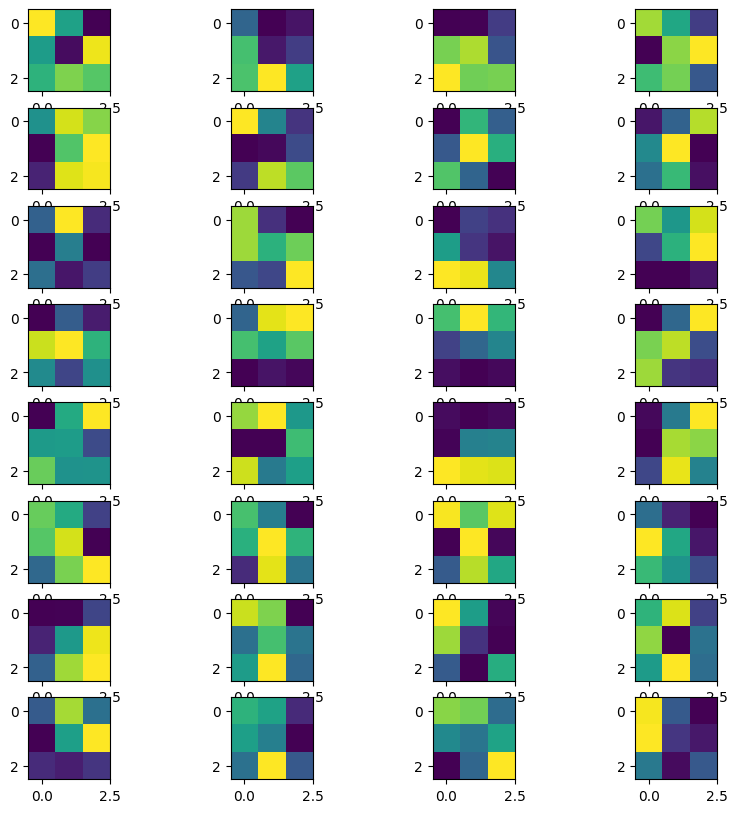

In [299]:
kernels = [i for i in basic_cnn_model.conv1.named_parameters() if i[0] == "weight"][0][1].detach().cpu().numpy()
len(kernels)
fig = plt.figure(figsize = (10,10))
for i,x in enumerate(kernels):
    ax = fig.add_subplot(8,32//8,i+1)
    ax.imshow(softmax(x)[0])


In [197]:
predictions = []
with torch.no_grad():
    for batch_x, batch_y in image_test_dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output = basic_cnn_model(batch_x)
        predictions.append(output.argmax(dim=1).detach().cpu().numpy())
predictions = np.concatenate(predictions)

In [201]:
classification_metrics(predictions,y_test)

{'Accuracy': 0.9829}


{'Accuracy': 0.9829}